In [13]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import imutils 
import seaborn as sns
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf


## **Data Loading**

In [14]:
data_dir = r"C:/Users/Asus/Downloads/Brain-Tumor-Detection-main/brain_tumor_dataset"

In [15]:
#Count images in the two folders: yes (Tumor) and no (Healthey)
dict_img = {}
for dir in os.listdir(data_dir):
    dict_img[dir] = len(os.listdir(os.path.join(data_dir, dir)))

dict_img

{'no': 98, 'yes': 155}

So we have 155 Brain MRI images with a tumor and 98 healthey ones. 

In [16]:
# Parameters
img_size = (224, 224)   # resize all images to 224x224
batch_size = 32

Text(0.5, 1.0, 'no')

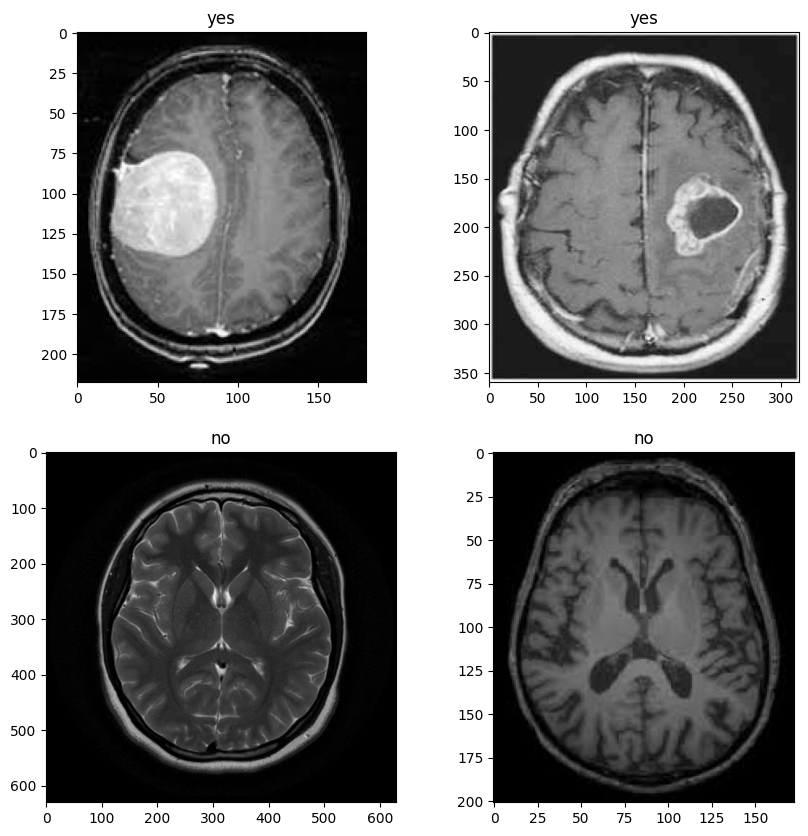

In [17]:
#Plot some MRI images
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(load_img(os.path.join('yes', os.listdir('yes')[0])))
plt.title('yes')
plt.subplot(2, 2, 2)
plt.imshow(load_img(os.path.join('yes', os.listdir('yes')[1])))
plt.title('yes')

plt.subplot(2, 2, 3)
plt.imshow(load_img(os.path.join('no', os.listdir('no')[0])))
plt.title('no')
plt.subplot(2, 2, 4)
plt.imshow(load_img(os.path.join('no', os.listdir('no')[1])))
plt.title('no')

## **Image Augmentation**

As much as our training set contains more data, the model's accuracy will improve. Data augmentation is a technique used to increase the amount of data by adding slightly modified copies of already existing data.

In [18]:
#Define a function for image augmentation
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest',
                                  rescale= 1/255
                                 )

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [20]:
#Create augmented images folders
#L = ['aug_train', 'aug_test', 'aug_val']
name = 'aug_data'
if not os.path.exists("./"+name):
  os.mkdir("./"+name)
  for dir in os.listdir(data_dir):
    os.makedirs("./"+name+"/"+dir)
else:
  print(f"{name} Already exists")

aug_data Already exists


In [22]:
# Create augmentation folders if they don't exist
os.makedirs("./aug_data/yes", exist_ok=True)
os.makedirs("./aug_data/no", exist_ok=True)

In [23]:
# Now run augmentation
augment_data(file_dir=r"C:/Users/Asus/Downloads/Brain-Tumor-Detection-main/brain_tumor_dataset/yes",
             n_generated_samples=8,
             save_to_dir="./aug_data/yes")

augment_data(file_dir=r"C:/Users/Asus/Downloads/Brain-Tumor-Detection-main/brain_tumor_dataset/no",
             n_generated_samples=12,
             save_to_dir="./aug_data/no")

## **Split data into train, validation and test sets**

In [28]:
#Count images in the two folders: yes (Tumor) and no (Healthey) in the folder of augmented images
root = "./aug_data"
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img 

{'no': 1273, 'yes': 1395}

In [29]:
#Define a function that creates new folders for the train, test and val sets and append random pictures to them based on the split percentage
def create_folders(name, perc):
  if not os.path.exists("./"+name):
    os.mkdir("./"+name)
    for dir in os.listdir(root):
      os.makedirs("./"+name+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root, dir)), size=(math.floor(perc*dict_img[dir])), replace=False):
        Src = os.path.join(root, dir, img)
        Dest = os.path.join("./"+name, dir)
        shutil.copy(Src, Dest)
        os.remove(Src)
  else:
    print(f"{name} Already exists")

In [30]:
#Create the training set
create_folders('train', 0.7)

In [31]:
#Create the test set
create_folders('test', 0.15)

In [32]:
#Create the validation set
create_folders('val', 0.15)

In [33]:
#Define a function that counts images in the folders: yes (Tumor) and no (Healthey)
def count_img(folder):
  dict_img = {}
  for dir in os.listdir(folder):
    dict_img[dir] = len(os.listdir(os.path.join(folder, dir)))
  return dict_img

In [34]:
#Count images in the training set
count_img('train')

{'no': 891, 'yes': 976}

In [35]:
#Count images in the test set
count_img('test')

{'no': 190, 'yes': 209}

In [36]:
#Count images in the validation set
count_img('val')

{'no': 190, 'yes': 209}

## **Image Preprocessing**

In [43]:
#Define a function that crop tha brain contour
def crop_brain_contour(image, plot=False):
    
    #Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    #Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    #Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

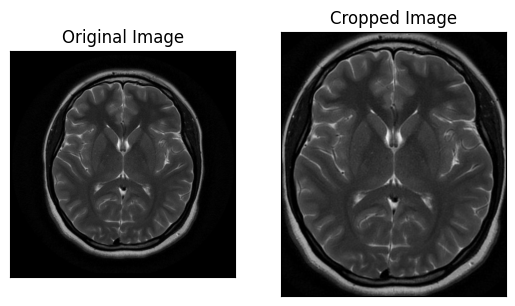

In [44]:
#Example
ex_img = cv2.imread('no/1 no.jpeg')
img = crop_brain_contour(ex_img, plot=True)

In [45]:
#Define a function that load data
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [47]:
#Load trainig data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_train, y_train = load_data([r"C:/Users/Asus/Downloads/Brain-Tumor-Detection-main/train/yes",
 r"C:/Users/Asus/Downloads/Brain-Tumor-Detection-main/train/no"], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1867
X shape is: (1867, 240, 240, 3)
y shape is: (1867, 1)


In [48]:
#Define a function that plot images
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

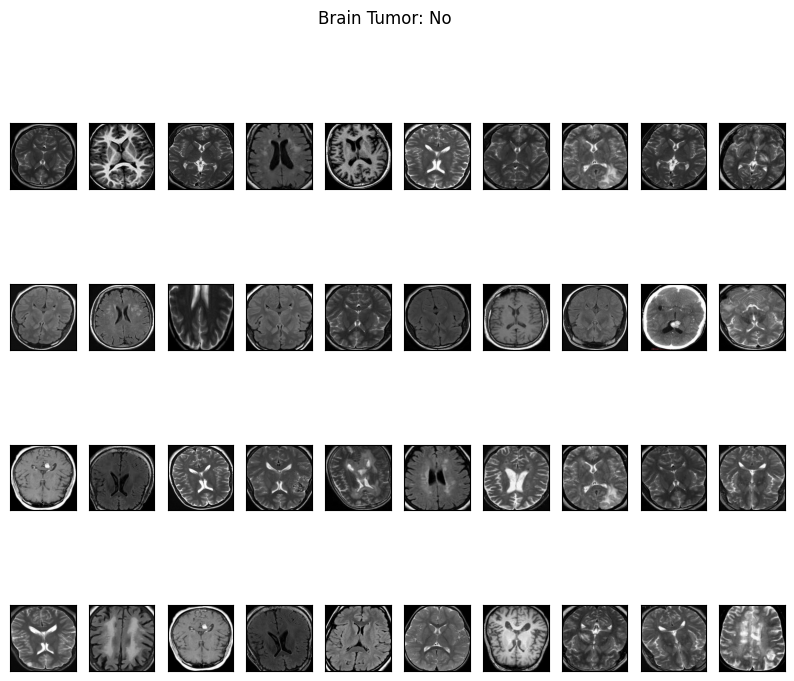

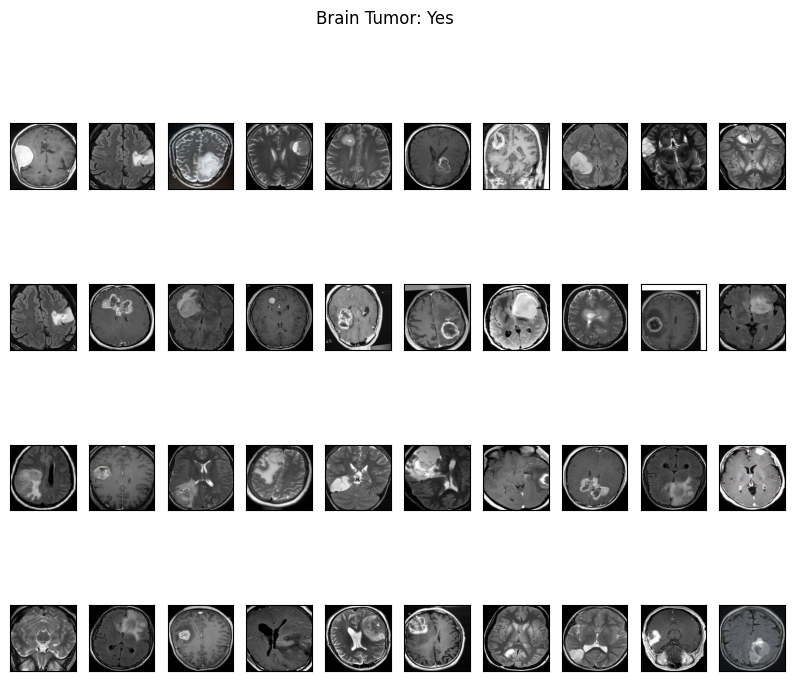

In [49]:
#Plot samples from the training set
plot_sample_images(X_train, y_train)

We can notice that the noise has been deleted and some images look alike with some slight changes resulted from the data augmentation

In [50]:
#Load test data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_test, y_test = load_data([r"C:/Users/Asus/Downloads/Brain-Tumor-Detection-main/test/yes",
 r"C:/Users/Asus/Downloads/Brain-Tumor-Detection-main/test/no"]
, (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 399
X shape is: (399, 240, 240, 3)
y shape is: (399, 1)


In [51]:
#Load validation data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_val, y_val = load_data([r"C:/Users/Asus/Downloads/Brain-Tumor-Detection-main/val/yes",
 r"C:/Users/Asus/Downloads/Brain-Tumor-Detection-main/val/no"], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 399
X shape is: (399, 240, 240, 3)
y shape is: (399, 1)


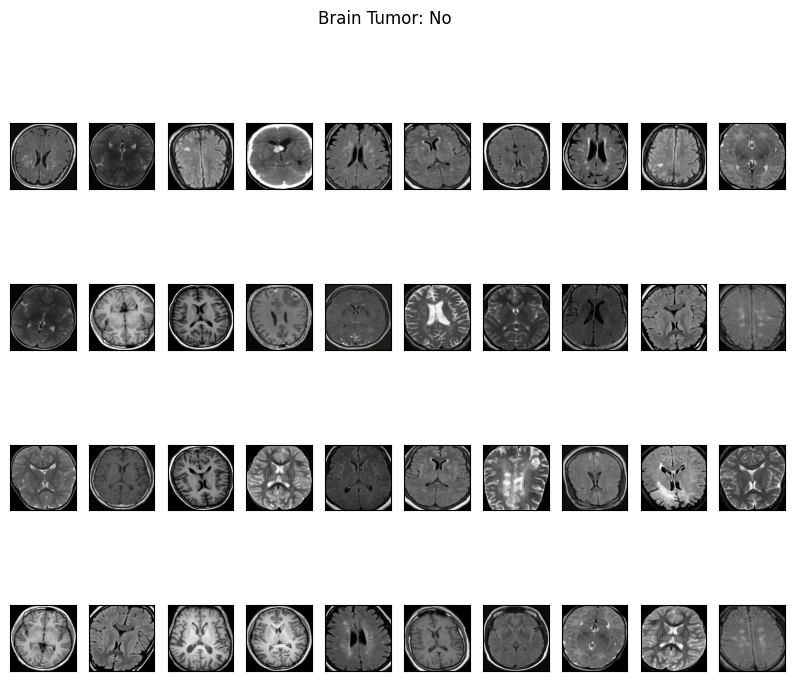

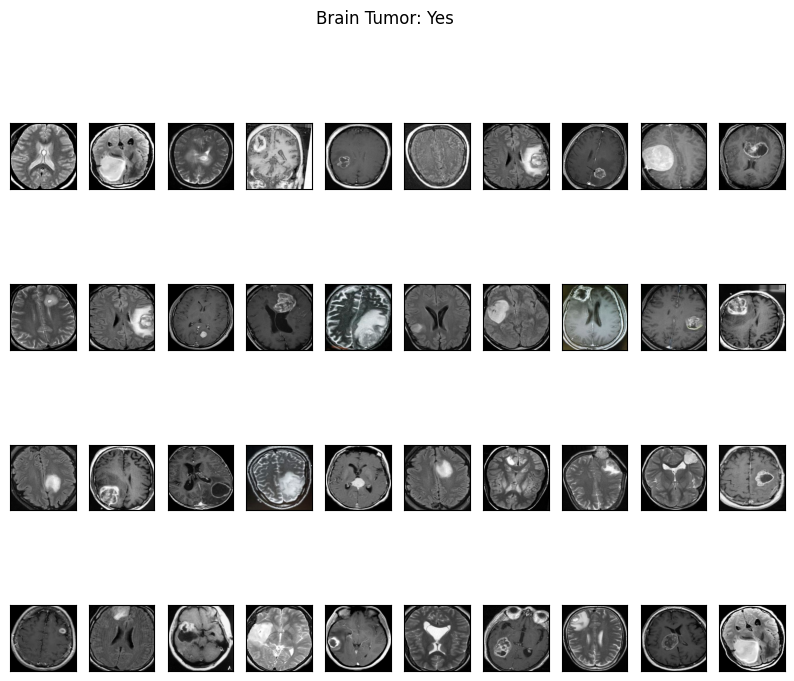

In [52]:
#Plot samples from the validation set
plot_sample_images(X_val, y_val)

## **CNN Model**

In [53]:
#Build our model
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (240, 240, 3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25)) 
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 238, 238, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 236, 236, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 118, 118, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 116, 116, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 58, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,520,097 (24.87 MB)

 Trainable params: 6,520,097 (24.87 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
from tensorflow.keras import losses

model.compile(
    optimizer='adam',
    loss=losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [56]:
#Early stopping and model checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor ='val_accuracy', filepath = './bestmodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cd = [es, mc]

In [57]:
#Train our model
hist = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cd, verbose = 1)

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - accuracy: 0.5378 - loss: 0.8204
Epoch 1: val_accuracy improved from None to 0.65163, saving model to ./bestmodel.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 903ms/step - accuracy: 0.5849 - loss: 0.6961 - val_accuracy: 0.6516 - val_loss: 0.6410
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.7216 - loss: 0.5771
Epoch 2: val_accuracy improved from 0.65163 to 0.79950, saving model to ./bestmodel.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 917ms/step - accuracy: 0.7574 - loss: 0.5186 - val_accuracy: 0.7995 - val_loss: 0.4314
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.8308 - loss: 0.3846
Epoch 3: val_accuracy improved from 0.79950 to 0.83459, saving model to ./bestmodel.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 52s 878ms/step - accuracy: 0.8216 - loss: 0.4088 - val_accuracy: 0.8346 - val_loss: 0.3836
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.8392 - loss: 0.3727
Epoch 4: val_accuracy improved from 0.83459 to 0.87469, saving model to ./bestmodel.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 52s 890ms/step - accuracy: 0.8356 - loss: 0.3705 - val_accuracy: 0.8747 - val_loss: 0.3527
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.8924 - loss: 0.2722
Epoch 5: val_accuracy improved from 0.87469 to 0.87719, saving model to ./bestmodel.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 52s 887ms/step - accuracy: 0.8886 - loss: 0.2714 - val_accuracy: 0.8772 - val_loss: 0.3036
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.9106 - loss: 0.2097
Epoch 6: val_accuracy did not improve from 0.87719
59/59 ━━━━━━━━━━━━━━━━━━━━ 51s 866ms/step - accuracy: 0.9041 - loss: 0.2243 - val_accuracy: 0.8722 - val_loss: 0.3163
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.9309 - loss: 0.1552
Epoch 7: val_accuracy did not improve from 0.87719
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 941ms/step - accuracy: 0.9336 - loss: 0.1556 - val_accuracy: 0.8647 - val_loss: 0.3706
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.9525 - loss: 0.1258
Epoch 8: val_accuracy did not improve from 0.87719
59/59 ━━━━━━━━━━━━━━━━━━━━ 51s 869ms/step - accuracy: 0.9550 - loss: 0.1122 - val_accuracy: 0.8647 - val_loss: 0.3918
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.9569 - loss: 0.1009
Epoch 9: val_accuracy improved 

59/59 ━━━━━━━━━━━━━━━━━━━━ 51s 870ms/step - accuracy: 0.9668 - loss: 0.0913 - val_accuracy: 0.8822 - val_loss: 0.3308
Epoch 9: early stopping


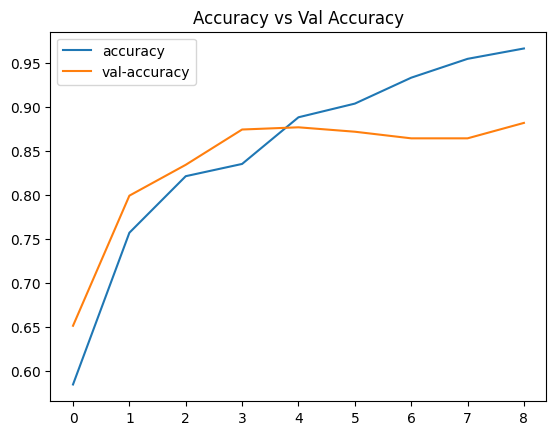

In [62]:
#Plot the graphical interpretation
h = hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

In [68]:
from keras.models import load_model

# Load the saved model
model = load_model(r"C:\Users\Asus\Downloads\Brain-Tumor-Detection-main\bestmodel.h5")

# Compile again (optional but recommended before evaluation)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate on test data
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc:.2f}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.8722 - loss: 0.3951
The accuracy of our model is 0.87


We can see that our model works well on the test set, so it's not overfitted

In [71]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Choose a MRI image with tumor
path = r"C:\Users\Asus\Downloads\Brain-Tumor-Detection-main\aug_data\yes\aug_Y259_0_6032.jpg"

img_yes = load_img(path, target_size=(240,240))
img_array_yes = img_to_array(img_yes) / 255.0
img_array_yes = np.expand_dims(img_array_yes, axis=0)

prediction1 = model.predict(img_array_yes)
class1 = np.round(prediction1).astype(int)

if class1 == 0:
    print("The MRI image doesn't have a Tumor")
else:
    print("The MRI image has a Tumor")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
The MRI image has a Tumor


In [82]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

#Choose a MRI image without tumor
path = r"C:\Users\Asus\Downloads\Brain-Tumor-Detection-main\aug_data\no\aug_3 no_0_8631.jpg"
img_no = load_img(path, target_size=(240,240))
img_array_no = img_to_array(img_no)/255.0
img_array_no = np.expand_dims(img_array_no, axis=0)

prediction2 = model.predict(img_array_no)[0][0]
class2 = np.round(prediction2).astype(int)

if class2 == 1:
    print("The MRI image doesn't have a Tumor")
else:
    print("The MRI image has a Tumor")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
The MRI image doesn't have a Tumor


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 392ms/step


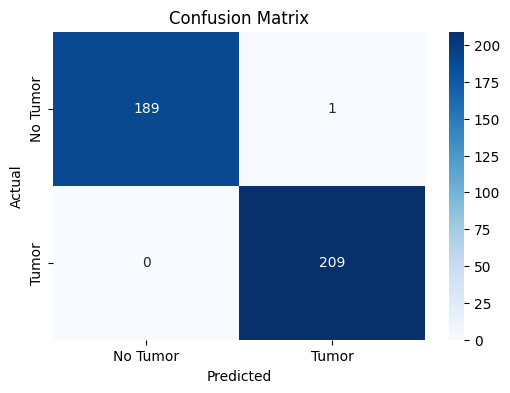

Classification Report:
              precision    recall  f1-score   support

    No Tumor       1.00      0.99      1.00       190
       Tumor       1.00      1.00      1.00       209

    accuracy                           1.00       399
   macro avg       1.00      1.00      1.00       399
weighted avg       1.00      1.00      1.00       399



In [102]:
from sklearn.metrics import classification_report, confusion_matrix

# Get model predictions on test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # convert probabilities to class labels (0/1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Tumor","Tumor"],
            yticklabels=["No Tumor","Tumor"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1-Score
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=["No Tumor","Tumor"]))
